# My (Painstaking) Attempt at the PSTH and CCH

The following are the modules that are imported. The ```math``` module is used in the fsubk function because $\exp(x)$ is used.The ```matplotlib.pyplot``` module is used obviously for graphical purposes. ```numpy``` for operating on arrays, including the very important broadcasting feature, getting samples from the uniform distribution, as well as other functions. The ```groupby``` function from the ```itertools``` module is used to randomly permute over the trials, while ```chain``` is a submodule which contains the ```from_iterable``` function used to unpack a nested generator into its parts. The ```numba``` module has a compiler called ```jit,``` which drastically reduces computation speed to be comparable at C++ levels. But this delight comes at a huge cost, namely a huge pain in the ass to debug (as some functions aren't supported by numba and other things). Finally, the ```time``` module contains a method ```time(),``` which is used to time executions.

In [1]:
import math as m 
import matplotlib.pyplot as plt 
import numpy as np 
from itertools import chain,groupby  
from numba import jit
from time import time

## f_k function

This is the f_k function used in the paper. The one that is:

$$f_{k}(t) = \left[10+\sum_{j=1}^{40}\sum_{l=-\infty}^{\infty}\frac{1}{2\sigma/\sqrt{2}}\exp\left(-\frac{|t+l-\mu_{j,k}|}{\sigma/\sqrt{2}}\right)\right]\mathbb{1}\{t\in[0,1)\}$$

You can simplify this to the following form (this is necessary for algorithmic reasons (at least was for me)):

$$f_{k}(t) = 10 + \frac{1}{\sigma\sqrt{2}}\sum_{j=1}^{40}\left[
\overbrace{\exp\left(\frac{\mu_{j,k}-t}{\sigma/\sqrt{2}}\right)\sum_{l=1}^{l=\infty}\exp\left(-\frac{l}{\sigma/\sqrt{2}}\right)}
^{\text{term 1}}+\overbrace{L(l=0)}^{\text{1 conditional term}}+\overbrace{\exp\left(\frac{t-\mu_{j,k}}{\sigma/\sqrt{2}}\right)
\sum_{l=-\infty}^{l=-1}\exp\left(\frac{l}{\sigma/\sqrt{2}}\right)}^{\text{term 2}}
\right]\mathbb{1}\{t\in[0,1)\}$$

where the $L(l=0)$ is a conditional term that looks like this:

$$L(l=0) = \left\{
\begin{array}{ll}
    \textrm{ if  }t\geq\mu_{j,k}\rightarrow & \exp\left(\frac{\mu_{j,k}-t}{\sigma/\sqrt{2}}\right) \\
    \textrm{ if  }t<\mu_{j,k}\rightarrow & \exp\left(\frac{t-\mu_{j,k}}{\sigma/\sqrt{2}}\right) \\
\end{array} 
\right.$$

I share a derivation of this simplification in my earlier jupyter notebooks. In this code ```ulist``` is a nested list of the 40 $\mu_{j,k}$ samples (100 since there are 100 trials). ```ulistpos``` is the positional argument for the trial number. For example, I have ```ulistpos=0``` in ```y = vfunc(t0=x,ulistpos=0)``` so I graph the function for the first trial. Another thing worthy of mentioning is that I don't vectorize over ```ulistpos```, only for the ```t0``` argument.

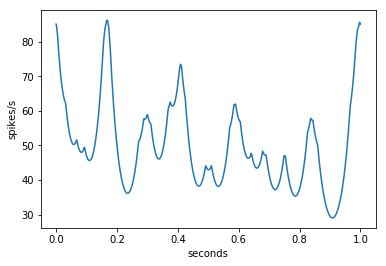

In [2]:
#just for jupyter so graphs are rendered properly within notebooks
%matplotlib inline 

sigma = 0.05 # by convention used in paper

ulist = [np.random.uniform(size=40) for i in range(0,100)]

# the fsubk function. Please see earlier jupyter notebook to understand this 
def fsubk(t0,ulistpos): 
    const = float(1/(m.exp((2**(1/2))/sigma)-1))
    s = ulist[ulistpos]
    a = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))*const),s))
    b = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))*const),s))
    c1 = [u for u in s if t0>=u]
    c2 = [u for u in s if t0<u]
    C1 = sum(map(lambda u: float(m.exp((u-t0)/(sigma/(2**(1/2))))),c1))
    C2 = sum(map(lambda u: float(m.exp((t0-u)/(sigma/(2**(1/2))))),c2))
    return float(((a+b+C1+C2)*(1/(sigma*(2**(1/2)))))+10)

vfunc = np.vectorize(fsubk,excluded=['ulistpos']) 
x = np.linspace(0,0.9999999999999,1000) 
y = vfunc(t0=x,ulistpos=0) 
plt.xlabel('seconds')
plt.ylabel('spikes/s')
plt.plot(x,y)
plt.show()

## Poisson Point Process

Here I prepare a vector of points on the domain across a single trial (aka ```midpoint_inputs```) and feed it to the subsequent ```function_outputs``` which takes in that vector and evaluates the function value at those points across 100 trials. Essentially, I'm preparing $\lambda(t)$'s for the Poisson Point Process. ```chain.from_iterable``` unpacks a nested generator into a list of multiple generators, then ```np.fromiter``` converts that list of multiple generators to the actual values. I must admit that this can be done more efficiently but I haven't changed it. NOTE: this will take about 4 minutes!!!

In [13]:
delta = 0.0001
midpoint_inputs = np.asarray([(i+0.5)*delta for i in range(0,int(1/delta))]) # midpoint approximation
function_outputs = np.fromiter(chain.from_iterable((vfunc(t0=midpoint_inputs,ulistpos=i) for i in range(0,100))),float)

Here the actual Poisson Point Process takes place. Essentially a bunch of coin flips: spike time at time $t$ iff $\lambda(t)\cdot\delta\geq U_{[0,1]}$. Simple as that. I do this for 2 neurons and I get the array of spike times ```times1``` and ```times2``` for neuron 1 and neuron 2, respectively. ```flipacoinrandoms1``` and ```flipacoinrandoms2``` are just list of samples from the uniform distribution for each neuron. If the conditional (just stated mathematically) is met, then I keep that respective input value that was once in ```midpoint_inputs```.

In [14]:
flipacoinrandoms1 = np.random.uniform(size=int(100/delta))
flipacoinrandoms2 = np.random.uniform(size=int(100/delta))
times1 = np.array([round((v+1/2)*delta,6) for v in range(0,int(100/delta)) if flipacoinrandoms1[v]<=float(function_outputs[v]*delta)])
times2 = np.array([round((v+1/2)*delta,6) for v in range(0,int(100/delta)) if flipacoinrandoms2[v]<=float(function_outputs[v]*delta)])

Let's check the length of these lists. It should be about 5000 even if I make delta finer.

In [15]:
len(times1),len(times2)

(5027, 5004)

In [16]:
type(times1[0])

numpy.float64

## Peri-Stimulus Time Histogram

Here I define ```fsubkav``` as the mean of ```fsubk``` across trials. ```psth1``` and ```psth2``` are the psth functions defined in the paper for neuron 1 and neuron 2, respectively. 

In [17]:
def fsubkav(t00):
    return np.mean(np.array([fsubk(t00,i) for i in range(0,100)]))

def psth1(t0):
    psthlist = [float(t0-0.025)<=times1[i]%1<float(t0+0.025) for i in range(0,len(times1))]
    return sum(psthlist)/(100*0.050)

def psth2(t0):
    psthlist = [float(t0-0.025)<=times2[i]%1<float(t0+0.025) for i in range(0,len(times2))]
    return sum(psthlist)/(100*0.050)

This is stuff used to plot the functions just defined. Pardon the naming of the variables! Also, note the use of ```start = time()```,```end = time()```, and ```print(end-start)``` to find the time of execution. NOTE: This takes about 24 seconds!!!

23.391083002090454


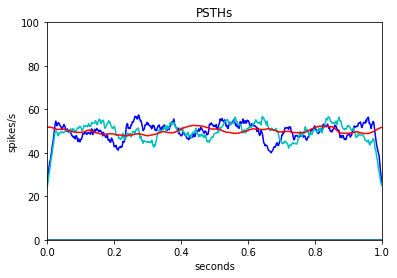

In [18]:
start = time()
t = np.linspace(0,1,500)
vfunc2 = np.vectorize(psth1)
y2 = vfunc2(t)
vfunc3 = np.vectorize(psth2)
y3 = vfunc3(t)
vfunc4 = np.vectorize(fsubkav)
y4 = vfunc4(t)
plt.axis([0,1,0,100])
plt.plot(t,y2,'b',t,y3,'c',t,y4,'r',t)
plt.title('PSTHs')
plt.xlabel('seconds')
plt.ylabel('spikes/s')
plt.yticks(np.arange(0,120,20))
plt.show
end = time()
print(end-start) # prints out how long it takes, used extensively in this notebook

## Cross-Correlation Histogram

The most challenging task I've faced! Since the formula for the CCH features a double summation, my intuition told me to skip a nested for loop (known to be computationally expensive) and go for a function that takes in parameter ```tau``` and ```cartprod```, the latter being short for cartesian product since you're essentially summing over every pair in the cartesian product of the sets ```times1``` and ```times2```. This function (now erased) took about 0.03 seconds. I've went back and tested the nested for loop I didn't believe in it before, but decided to give it a try. Ironically, this turned out to be the fastest, with a speed of 0.009 seconds. This function is ```cch_jit3```. It has a decorator called ```@jit(nopython=True)``` used to speed it up (thanks to the compiler module called numba). But beware, however, not everything can be jitted (coming from ```@jit```) due to the fact that not all functions are supported. One working with this will be forced to extensively look at the documentation of supported features. One last thing to mention, the ```np.logical_and(np.greater_equal(i-j,tau-0.001),np.less(i-j,tau+0.001))``` part of the function results either in ```True``` (1) or ```False``` (0), so it is adding a bunch of 1's and 0's.

In [19]:
@jit(nopython=True)
def cch_jit3(tau,train1,train2):
    sum = 0
    for i in train1:
        for j in train2:
            sum+=np.logical_and(np.greater_equal(i-j,tau-0.001),np.less(i-j,tau+0.001))
    return sum

Let's confirm the timing of the execution. As it was stated, it should be in the ballpark of 0.009 seconds. First execution doesn't count because that's when it takes time to do the compiling. 

In [22]:
start = time()
cch_jit3(0,times1,times2)
end = time()
end-start

0.007985830307006836

This part of the code is just to graph a CCH (without the acceptance bands, yet). Nothing new here except 1 thing. For some strange reason, a combination of ```np.fromiter``` and ```map``` tends to be a tad faster than ```np.vectorize```. NOTE: this should take about 6.7 seconds to graph!!!

7.037532091140747


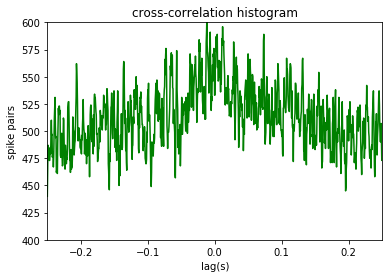

In [23]:
start = time()
t2 = np.linspace(-.250,.250,1000)
y6 = np.fromiter(map(lambda r: cch_jit3(r,times1,times2),t2),float) # used a combo of np.fromiter and map
                                                              # since it seems a bit faster then np.vectorize                                                 
plt.plot(t2,y6,'g')
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,400,600])
end = time()
print(end-start)

## Acceptance Bands

Here ```times_trial_pairs``` is a list of pairs in the format (trial #,time). Notice how ```np.floor``` gives the trial # that time belongs to, since a trial is 1 second long. I use the ```groupby``` function from itertools to group the times by their trial #. ``` lambda x: x[0]``` says, take the first entry in every pair in ```times_trial_pairs``` and associate that as the group. ```groups``` is a nested list, a list of grouped lists. Finally, ```[np.random.permutation(groups) for i in range(1,10000)]``` permutes the placement of each element in groups each 9999 times and then is a list classified as ```shuffled_v_all```.

To further facilitate in understanding, take a look at this SO post:
https://stackoverflow.com/questions/35214352/shuffle-groups-of-sublists-in-python

In [24]:
times_trial_pairs = np.asarray(list(zip(np.floor(times1),times1)))
groups = np.array([np.asarray(list(group)) for _,group in groupby(times_trial_pairs,lambda x: x[0])])
shuffled_v_all = [np.random.permutation(groups) for i in range(1,10000)]

This code block involves a bit of restructuring. The asterix is there to unpack a list into its constituents. The role of ```np.hstack``` is to concatenate horizontally all the (now shuffled) elements in ```groups``` for every ```groups``` in ```shuffled_v_all```. NOTE: This may take about 3 minutes!!!

In [25]:
times_trial_shuffled = np.array([np.hstack(([list(zip(*shuffled_v_all[j][i]))[1] for i in range(0,100)])) for j in range(0,9999)])

I take ```%1``` or modulo 1 for every entry since the trial # is out of order for all of them. Thanks to numpy array broadcasting, I can attach the trial #'s so that everything is in order (cch's care about order). ```times_trial_shuffled``` is a list of 9999 shuffled (by trial) surrogate spike trains!

In [26]:
for i in range(0,9999):
    times_trial_shuffled[i] = times_trial_shuffled[i]%1 + np.floor(times1)

Repeating the same procedure just detailed, now for neuron 2 (this is optional):

In [27]:
times_trial_pairs2 = np.asarray(list(zip(np.floor(times2),times2)))
groups2 = np.array([np.asarray(list(group)) for _,group in groupby(times_trial_pairs2,lambda x: x[0])])
shuffled_v_all2 = [np.random.permutation(groups2) for i in range(1,10000)]

In [28]:
times_trial_shuffled2 = np.array([np.hstack(([list(zip(*shuffled_v_all2[j][i]))[1] for i in range(0,100)])) for j in range(0,9999)])

In [29]:
for i in range(0,9999):
    times_trial_shuffled2[i] = times_trial_shuffled2[i]%1 + np.floor(times2)

```c_shuffled_list``` is a function that returns a (unsorted) list like this: $\left[c_{1}(\tau),\dots,c_{9999}(\tau)\right]$. This excludes the original $c_{0}(\tau)$. NOTE: This takes about 65 seconds!!!

In [30]:
def c_shuffled_list(Tau,Times_Trial_Shuffled,Times_Trial_Shuffled2):
    r = []
    r.append(cch_jit3(Tau,times1,times2))
    for k in range(0,9999):
        r.append(cch_jit3(Tau,Times_Trial_Shuffled[k],Times_Trial_Shuffled2[k]))
    return r

set $c_{0}(0)$ as a variable ```x``` so computer doesn't have to recompute it every time in the list comprehension for the function p_value (see below)

In [31]:
x = cch_jit3(0,times1,times2)

Set ```c_shuffled_list``` at lag 0 to a variable ```w``` so it memorizes it without having to compute it over and over. Same reasoning as above.

In [32]:
start = time()
w = c_shuffled_list(0,times_trial_shuffled,times_trial_shuffled2) 
end=time()
end-start

67.96992301940918

Let's see what ```x``` looks like...

In [33]:
x

537

```p_value()``` generates the p-value...

In [35]:
# computes the p value. c_0 >= c_0 so that's why there's a "1 +"
# thanks to the x, it doesn't have to do cch_jit(0,cartprod) over and over. 
# Uses what it stored (which is the x)

def p_value():
    return float((1+np.sum([1 for k in range(0,9999) if w[k]>=x]))/10000)

p_value()

0.071

This is a histogram of all $c_{i}(0)$. You might have to tinker around with the value for the ```bins``` parameter to make it visually appealing. The semicolon at the end hides extra unnecessary output, just like in MATLAB.

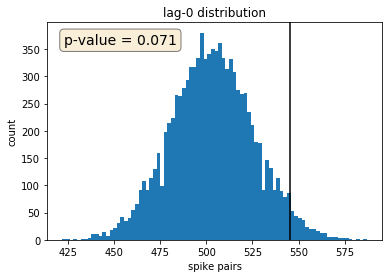

In [57]:
fig,ax = plt.subplots(1)
plt.hist(w,bins=84);
plt.title('lag-0 distribution')
plt.xlabel('spike pairs')
plt.ylabel('count')
plt.axvline(x=(1-p_value())*np.max([np.max(w),x]),color='k')
textstr = 'p-value = %s'%(p_value())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);

In [58]:
def upperbands(tau):
    hello = np.array(c_shuffled_list(tau,times_trial_shuffled,times_trial_shuffled2))
    hello.sort(kind='heapsort')
    return hello[9750]

In [59]:
def lowerbands(tau):
    hello = np.array(c_shuffled_list(tau,times_trial_shuffled,times_trial_shuffled2))
    hello.sort(kind='heapsort')
    return hello[250]

In [61]:
start = time()
upperbands(0)
end = time()
end-start

69.2643609046936

Yea... naming is bad. Was thinking of eminems... Anyway, the ```[:-1]``` says, take all the values except the last one. Mimicking $M-1$. What ```c_eminems_v``` stands for is sample mean:

$$\nu(\tau)=\frac{1}{M-1}\sum_{i=1}^{M-1}c_{(i)}(\tau)$$

In [170]:
def c_eminems_v(tau):
    hello = np.array(c_shuffled_list(tau,times_trial_shuffled,times_trial_shuffled2))
    hello.sort(kind='heapsort')
    return np.mean(hello[:-1])

NOTE: Every call to this function is about 70 seconds!!!

In [171]:
start = time()
v_0 = c_eminems_v(0)
end = time()
end-start

67.53650212287903

In [226]:
v_0

498.3172317231723

Similarly, ```c_eminems_s``` is the sample standard deviation. I used ```heapsort``` as the sorting algorithm for no particular reason, just like previously. I decided not to attach the original $c_{0}(\tau)$ since it wouldn't drastically change anything and why kill ourselves with some extra time? Also, the ```ddof=1``` parameter makes this sample std unbiased

$$s(\tau)=\sqrt{\frac{1}{M-2}\sum_{i=1}^{M-1}(c_{(i)}(\tau)-\nu(\tau))^2}$$

In [203]:
def c_eminems_s(tau):
    hello = np.array(c_shuffled_list(tau,times_trial_shuffled,times_trial_shuffled2))
    hello.sort(kind='heapsort')
    hello = hello[:-1]
    return np.std(hello,ddof=1)

NOTE: This takes about 70 seconds!!!

In [204]:
start = time()
s_0 = c_eminems_s(0)
end = time()
end-start

67.13817119598389

In [205]:
s_0

22.96332809034454

```c_eminems_minus``` computes $c^{-}_{0.025M}$. As in,

$$c^{-}_{0.025M}=\min_{\tau}\frac{c_{0.025M}(\tau)-\nu(\tau)}{s(\tau)}$$

In [210]:
def c_eminems_minus(n):
    x = np.linspace(-0.25,0.25,n)
    q = []
    for u in x:
        q.append((np.sort(c_shuffled_list(u,times_trial_shuffled,times_trial_shuffled2))[250]-c_eminems_v(u))/c_eminems_s(u))
    return min(q)

NOTE: This takes about 1000 seconds for 5 samples across the domain [-0.25,0.25]!!!

In [211]:
start = time()
minus = c_eminems_minus(5)
end = time()
end-start

1003.8196430206299

In [213]:
minus

-1.9734609698072025

```c_eminems_plus``` computes $c_{0.975M}^{+}$. As in,

$$c_{0.975M}^{+}=\max_{\tau}\frac{c_{0.975M}(\tau)-\nu(\tau)}{s(\tau)}$$

In [214]:
def c_eminems_plus(n):
    x = np.linspace(-0.25,0.25,n)
    w = []
    for v in x:
        w.append((np.sort(c_shuffled_list(v,times_trial_shuffled,times_trial_shuffled2))[9750]-c_eminems_v(v))/c_eminems_s(v))
    return max(w)

NOTE: This also takes in about 1000 seconds!!!

In [215]:
start = time()
plus = c_eminems_plus(5)
end = time()
end-start

1004.8215708732605

In [216]:
plus

2.0477198008588218

Let's graph the cch again, but now with the acceptance bands. Forgot to change the color! NOTE: This takes about 1360 seconds!!!

1359.6257181167603


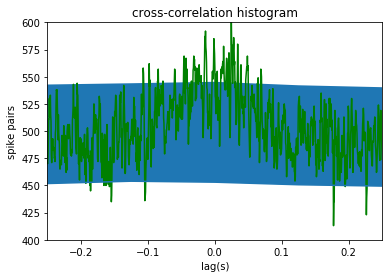

In [235]:
start = time()
t2 = np.linspace(-.250,.250,1000) #1250
t2a = np.linspace(-0.25,0.25,5)
y6 = np.fromiter(map(lambda r: cch_jit3(r,times1,times2),t2),float)                                             
plt.plot(t2,y6,'g')
y7 = list(map(lambda r: minus*c_eminems_s(r)+c_eminems_v(r),t2a))
y8 = list(map(lambda r: plus*c_eminems_s(r)+c_eminems_v(r),t2a))
plt.fill_between(t2a,y7,y8)
plt.plot(t2a,y7)
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,400,600])
end = time()
print(end-start)

687.6404070854187


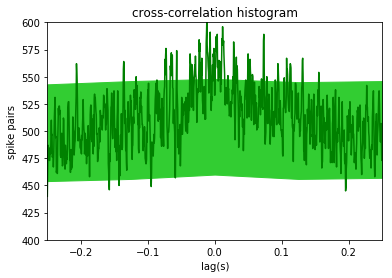

In [62]:
start = time()
t2 = np.linspace(-.250,.250,1000) #1250
t2a = np.linspace(-0.25,0.25,5)
y6 = np.fromiter(map(lambda r: cch_jit3(r,times1,times2),t2),float)                                             
plt.plot(t2,y6,'g')
y7 = list(map(lambda r: upperbands(r),t2a))
y8 = list(map(lambda r: lowerbands(r),t2a))
plt.fill_between(t2a,y7,y8,color='limegreen')
plt.title('cross-correlation histogram')
plt.xlabel('lag(s)')
plt.ylabel('spike pairs')
plt.axis([-0.25,0.25,400,600])
end = time()
print(end-start)